# Update Packages

In [1]:
!pip install git+https://github.com/PytorchLightning/pytorch-lightning.git@1.0.0rc4 --upgrade

  Cloning https://github.com/PytorchLightning/pytorch-lightning.git (to revision 1.0.0rc4) to /tmp/pip-req-build-q9r0puyt
  Running command git clone -q https://github.com/PytorchLightning/pytorch-lightning.git /tmp/pip-req-build-q9r0puyt
  Running command git checkout -q 95581626118440079d4162126db3feeba441ed98
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


  Created wheel for pytorch-lightning: filename=pytorch_lightning-1.0.0rc4-py3-none-any.whl size=483622 sha256=9186ee009ddf223cd958384acfc1f57c2be9be4da217f42d9d65bf7522ca9a9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-vlnesql5/wheels/90/fc/b6/d9f9c135a26d48c2c4f32fb932ad34fc79ecbe7c5a22af96c6
Successfully built pytorch-lightning
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.0.0rc4
    Uninstalling pytorch-lightning-1.0.0rc4:
      Successfully uninstalled pytorch-lightning-1.0.0rc4


# Imports

In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from pytorch_lightning import LightningDataModule, LightningModule
from pytorch_lightning.metrics import Accuracy

from net import DogsBreedClassifier
from net_transfer_densenet121 import DogsBreedClassifierDenseNet
from net_transfer_EfficientNet import DogsBreedClassifierEfficientNet

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from datamodule import DogsDataModule

%load_ext tensorboard

# Data

In [2]:
paths = {
    'train': './dog_images/train/',
    'test': './dog_images/test/',
    'val': './dog_images/valid/'
}

dm = DogsDataModule(paths)

# Utility functions

In [3]:
def calculate_accuracy(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """Calculate accuracy of a given model using data module.
    
    Args: 
        preds: Tensor containing predictions
        targets: Tensor containing target value
            
    Returns: 
        A float value indicating the model's accuracy calculated on a given dataset.
    
    """
    accuracy = Accuracy()
    
    accuracy(preds, targets)
        
    return accuracy.compute()

def calculate_metrics(model: LightningModule, datamodule: LightningDataModule) -> (float, float, float, float, np.ndarray):
    """Calculate metrics for a given model using data module.
    
    Args: 
        model: Instance of LightningModule containing model
        datamodule: Instance of LightningDataModule containing test_dataloader
            which can be used for test evalution.
            
    Returns:
        A tuple containing the following metrics: accuracu, f1 score, presicion, recall, confusion matrix
    """
    
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    #Iterate through the dataset and obtain all predictions
    for data, labels in dm.test_dataloader():
        y_hat = model(data)
        
        all_predictions.extend(torch.argmax(y_hat, dim=1).numpy())
        all_labels.extend(labels.numpy())    
        
    acc = calculate_accuracy(torch.IntTensor(all_predictions), torch.IntTensor(all_labels))
    score = f1_score(all_labels, all_predictions, average='macro')
    presicion = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    
    cmatrix = confusion_matrix(all_labels, all_predictions)
    
    return (acc, score, presicion, recall, cmatrix)

def display_confusion_matrix(cmatrix, classes):
    plt.figure(figsize=(15, 15))
    
    ax = plt.gca()
    ax.matshow(cmatrix, cmap='Reds')
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()

# Models

## Scratch Model

### Instantiating the model using existing weights

In [5]:
path_to_checkpoint = './logs/scratch_model_logs/lightning_logs/version_0/checkpoints/epoch=14.ckpt'
scratch_model = DogsBreedClassifier.load_from_checkpoint(path_to_checkpoint)

### Metrics. Confusion Matrix.

/home/sergey/anaconda3/envs/dog_breed_classifier/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.233%
F1 Score: 0.201
Presicion: 0.243
Recall: 0.217


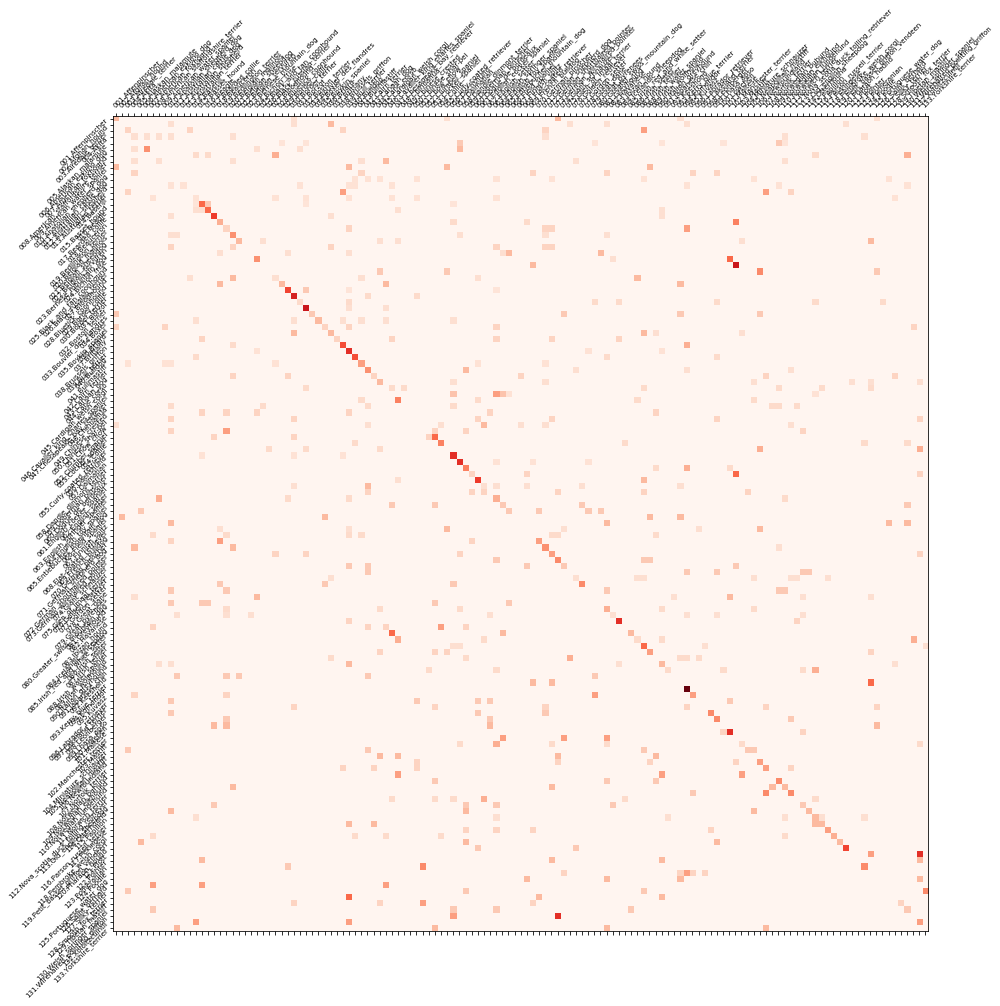

In [6]:
(accuracy, f1, presicion, recall, cmatrix) = calculate_metrics(scratch_model, dm)

print(f'Accuracy: {accuracy:.3f}%')
print(f'F1 Score: {f1:.3f}')
print(f'Presicion: {presicion:.3f}')
print(f'Recall: {recall:.3f}')

cmatrix = (cmatrix.T / cmatrix.sum(axis=1)).T

display_confusion_matrix(cmatrix, dm.train_dataloader().dataset.class_to_idx)

### Tensorboard

In [7]:
%tensorboard --logdir logs/scratch_model_logs/

Reusing TensorBoard on port 6006 (pid 69823), started 3:35:35 ago. (Use '!kill 69823' to kill it.)

## DenseNet121 model

### Instantiating the model using existing weights

In [8]:
path_to_checkpoint = './logs/transfer_densenet_logs/lightning_logs/version_0/checkpoints/epoch=2.ckpt'
densenet_model = DogsBreedClassifierDenseNet.load_from_checkpoint(path_to_checkpoint)

### Metrics. Confusion Matrix.

Accuracy: 0.794%
F1 Score: 0.769
Presicion: 0.819
Recall: 0.780


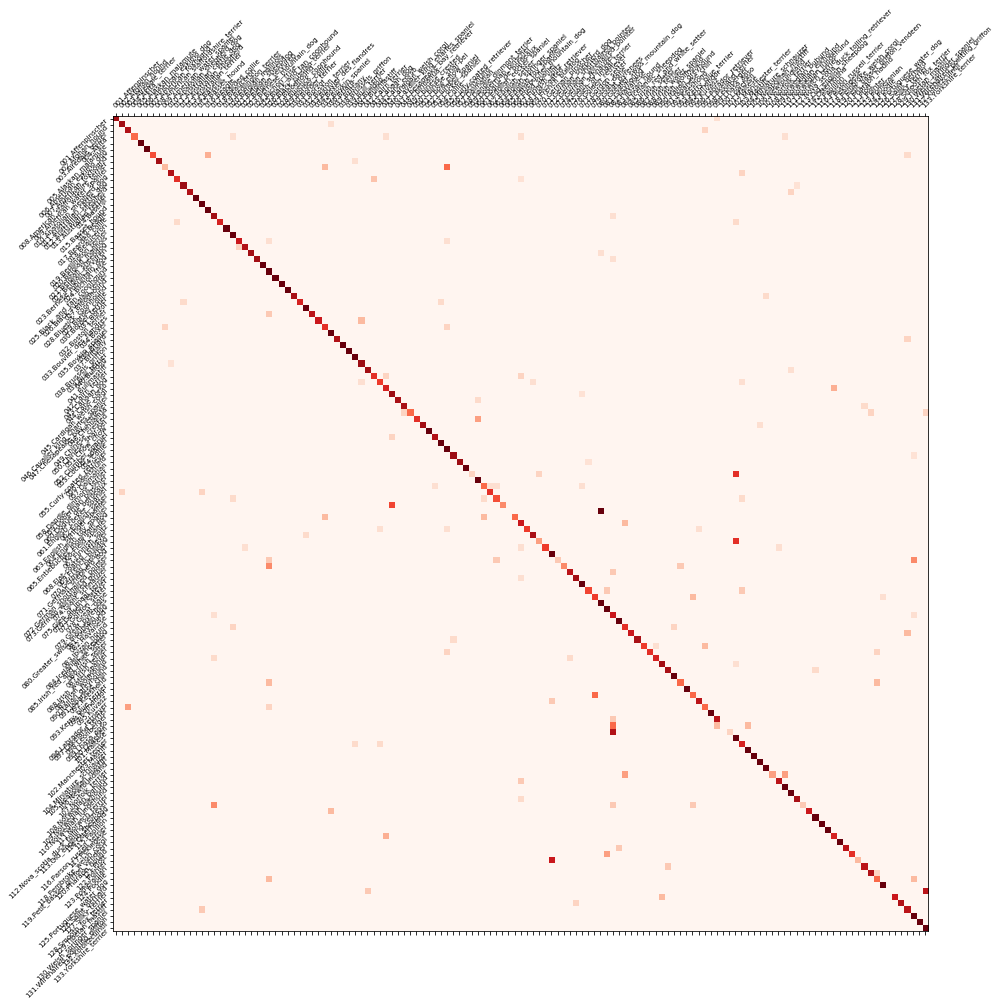

In [9]:
(accuracy, f1, presicion, recall, cmatrix) = calculate_metrics(densenet_model, dm)

print(f'Accuracy: {accuracy:.3f}%')
print(f'F1 Score: {f1:.3f}')
print(f'Presicion: {presicion:.3f}')
print(f'Recall: {recall:.3f}')

cmatrix = (cmatrix.T / cmatrix.sum(axis=1)).T

display_confusion_matrix(cmatrix, dm.train_dataloader().dataset.class_to_idx)

### Tensorboard

In [10]:
%tensorboard --logdir logs/transfer_densenet_logs/

Reusing TensorBoard on port 6007 (pid 71738), started 3:07:02 ago. (Use '!kill 71738' to kill it.)

## EfficientNet model

### Instantiating the model using existing weights

In [4]:
path_to_checkpoint = './logs/transfer_efficientnet_logs/lightning_logs/version_0/checkpoints/epoch=4.ckpt'
efficientnet_model = DogsBreedClassifierEfficientNet.load_from_checkpoint(path_to_checkpoint)

Loaded pretrained weights for efficientnet-b6


### Metrics. Confusion Matrix.

In [ ]:
(accuracy, f1, presicion, recall, cmatrix) = calculate_metrics(efficientnet_model, dm)

print(f'Accuracy: {accuracy:.3f}%')
print(f'F1 Score: {f1:.3f}')
print(f'Presicion: {presicion:.3f}')
print(f'Recall: {recall:.3f}')

cmatrix = (cmatrix.T / cmatrix.sum(axis=1)).T

display_confusion_matrix(cmatrix, dm.train_dataloader().dataset.class_to_idx)

### Tensorboard

In [ ]:
%tensorboard --logdir logs/transfer_efficientnet_logs/